In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
pd.set_option('display.max_columns', None)

#### Load the experiment df `ca1_train` and `ca1_test`

In [4]:
ca1_train = pd.read_parquet('../data/interim/predictive_ca1_train.to_parquet')
ca1_test = pd.read_parquet('../data/interim/predictive_ca1_test.to_parquet')

In [6]:
import sys
sys.path.insert(0, '../src')

#### Import the `preprocess` function to preprocess the data
- Extract date-related features from the `date` column
- Add `seasonality-feature`
- `Label Encoding` the categorical features
- Drop `id`, `date`, `wm_yr_wk`, `d`,  `event_name`, `event_type` features

In [7]:
from features.data_prep import preprocess

In [8]:
df_train, item_id_encoder, dept_id_encoder, store_id_encoder, state_id_encoder, cat_id_encoder = preprocess(ca1_train.copy())

In [9]:
df_test = preprocess(ca1_test.copy())[0]

In [10]:
df_train

,item_id,dept_id,cat_id,store_id,state_id,sales,sell_price,year,month,week_number,day_of_week,season_sin,season_cos
0,1437,3,1,0,0,0,8.296590,2011,1,1,5,0.500000,0.866025
1,1438,3,1,0,0,0,3.967419,2011,1,1,5,0.500000,0.866025
2,1439,3,1,0,0,0,2.965568,2011,1,1,5,0.500000,0.866025
3,1440,3,1,0,0,0,4.500594,2011,1,1,5,0.500000,0.866025
4,1441,3,1,0,0,0,2.881908,2011,1,1,5,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47079604,1432,2,0,0,0,3,2.880000,2015,4,221,5,0.866025,-0.500000
47079605,1433,2,0,0,0,0,2.680000,2015,4,221,5,0.866025,-0.500000
47079606,1434,2,0,0,0,2,3.980000,2015,4,221,5,0.866025,-0.500000
47079607,1435,2,0,0,0,0,1.280000,2015,4,221,5,0.866025,-0.500000


In [11]:
df_test

,item_id,dept_id,cat_id,store_id,state_id,sales,sell_price,year,month,week_number,day_of_week,season_sin,season_cos
47107050,1437,3,1,0,0,0,8.26,2015,4,222,6,0.866025,-0.500000
47107051,1438,3,1,0,0,0,3.97,2015,4,222,6,0.866025,-0.500000
47107052,1439,3,1,0,0,0,2.97,2015,4,222,6,0.866025,-0.500000
47107053,1440,3,1,0,0,4,4.64,2015,4,222,6,0.866025,-0.500000
47107054,1441,3,1,0,0,3,2.88,2015,4,222,6,0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59275604,1432,2,0,0,0,2,2.98,2016,5,279,6,0.500000,-0.866025
59275605,1433,2,0,0,0,0,2.48,2016,5,279,6,0.500000,-0.866025
59275606,1434,2,0,0,0,1,3.98,2016,5,279,6,0.500000,-0.866025
59275607,1435,2,0,0,0,1,1.28,2016,5,279,6,0.500000,-0.866025


#### Import `extract_features_target` function

In [12]:
from features.data_prep import extract_features_target

In [13]:
X_train, X_test, y_train, y_test = extract_features_target(df_train, df_test, 'sales')

#### Imoprt the `XGBRegressor`, and use `RMSE` as a performance metrics.

In [15]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error

#### Run the experiment of the `learning_rate` and `max_depth` features:
- `learning_rate`: from range 0.16 - 0.32 with a step of 0.05.
- `max_depth`: from range 3 to 10.

In [16]:
learning_rate = np.arange(0.16, 0.32, 0.05)
max_depth = np.arange(3, 10)

for lr in learning_rate:
    for md in max_depth:
        xgb_ht = XGBRegressor(objective = 'reg:tweedie', learning_rate = lr, max_depth = md, subsample = 0.7, 
                            colsample_bytree = 0.7, n_estimators = 100) 
        
        xgb_ht.fit(X_train,y_train)
        y_pred = xgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred, squared=False)

        print(f"Learning Rate: {lr}, Max Depth: {md},\n  RMSE Sales: {rmse}")
        print("\n")

Learning Rate: 0.16, Max Depth: 3,
  RMSE Sales: 3.2950507984844903


Learning Rate: 0.16, Max Depth: 4,
  RMSE Sales: 3.2450867431043404


Learning Rate: 0.16, Max Depth: 5,
  RMSE Sales: 3.1891138156021834


Learning Rate: 0.16, Max Depth: 6,
  RMSE Sales: 3.130615814482237


Learning Rate: 0.16, Max Depth: 7,
  RMSE Sales: 3.0588201516799427


Learning Rate: 0.16, Max Depth: 8,
  RMSE Sales: 2.9992580093007337


Learning Rate: 0.16, Max Depth: 9,
  RMSE Sales: 2.965083909687047


Learning Rate: 0.21000000000000002, Max Depth: 3,
  RMSE Sales: 3.301377468066603


Learning Rate: 0.21000000000000002, Max Depth: 4,
  RMSE Sales: 3.235255484846304


Learning Rate: 0.21000000000000002, Max Depth: 5,
  RMSE Sales: 3.1778479139374145


Learning Rate: 0.21000000000000002, Max Depth: 6,
  RMSE Sales: 3.1034046246907785


Learning Rate: 0.21000000000000002, Max Depth: 7,
  RMSE Sales: 3.014143740012374


Learning Rate: 0.21000000000000002, Max Depth: 8,
  RMSE Sales: 2.945859138048955


Learni

#### The best parameters for
- `learning_rate`: 0.31
- `max_depth`: 0.9

In [17]:
xgb = XGBRegressor(objective='reg:tweedie', learning_rate=0.31, max_depth=9, subsample=0.7, colsample_bytree=0.7, n_estimators=100)
xgb.fit(X_train,y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', verbose=10)

/Users/narongvatchingpayakmon/Projects/Spring2023/adv_mla_2023/adv_mla_at2_14229898/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:3.52269
[10]	validation_0-rmse:3.17375
[20]	validation_0-rmse:3.04614
[30]	validation_0-rmse:3.00300
[40]	validation_0-rmse:2.95118
[50]	validation_0-rmse:2.94681
[60]	validation_0-rmse:2.94006
[70]	validation_0-rmse:2.92893
[80]	validation_0-rmse:2.92636
[90]	validation_0-rmse:2.91215
[99]	validation_0-rmse:2.89712


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.31, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

#### Plot the Feature Importance

In [20]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

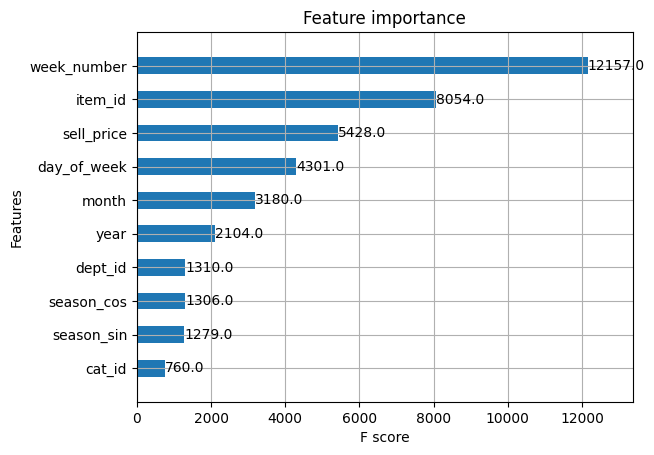

In [21]:
plot_importance(xgb, height=0.5)

In [30]:
y_pred = xgb.predict(X_test)

predicted_sales = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
predicted_sales

,y_test,y_pred
47107050,0,0.950115
47107051,0,0.407104
47107052,0,0.364419
47107053,4,2.460014
47107054,3,1.216105
...,...,...
59275604,2,4.075340
59275605,0,1.879305
59275606,1,2.549330
59275607,1,1.857960


In [31]:
predicted_revenue = pd.DataFrame({'y_test': X_test['sell_price'] * y_test, 'y_pred': X_test['sell_price'] * y_pred})
predicted_revenue

,y_test,y_pred
47107050,0.00,7.847948
47107051,0.00,1.616201
47107052,0.00,1.082326
47107053,18.56,11.414467
47107054,8.64,3.502382
...,...,...
59275604,5.96,12.144514
59275605,0.00,4.660677
59275606,3.98,10.146334
59275607,1.28,2.378189


In [32]:
rmse = mean_squared_error(predicted_revenue['y_test'], predicted_revenue['y_pred'], squared=False)
print(rmse)

9.870305299833557
